# Necessary Imports and Unnecessary TF Message/Warning Suppression

In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys

In [17]:
import numpy as np
from typing import Callable
import tensorflow as tf
import random
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import trange
from termcolor import cprint
from IPython.display import display, HTML

In [18]:
for dev in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(dev, True)

# Define Methods to Calculate Objective function, Gradient, L-smoothness constant and strong convexity constant

The functions `objective()`, `grad_objective()`, `numerical_gradient()` are crafted to work for single as well as batch-wise inputs(`thetas`) for efficiency.

In [19]:
def objective(thetas, Q, epsilon, w):
    '''
    Calculates:
        f(θ) = θᵀQθ + ε sin(wᵀθ)
    for a given theta.
    
    Arguments:
        - thetas: A single theta vector `[d]` or a batch of theta vectors `[batch_size, d]`.
        - Q: A positive definite matrix `[d, d]`.
        - epsilon: A small scalar.
        - w: A vector `[d]`.
        
    Returns:
        - The objective function value: a scalar if single theta, `[batch_size]` if batched.
    '''

    is_single = len(thetas.shape) == 1
    if is_single:
        thetas = tf.expand_dims(thetas, axis=0)

    Qthetas = tf.linalg.matvec(Q, thetas)
    thetaQthetas = tf.einsum('bd,bd->b', thetas, Qthetas)

    inner = tf.einsum('bd,d->b', thetas, w) 
    f = thetaQthetas + epsilon * tf.math.sin(inner)
    
    return f[0] if is_single else f


def grad_objective(thetas, Q, epsilon, w):
    '''
    Calculates:
       ∇θ (θᵀQθ + ε sin(wᵀθ)) = (Q + Qᵀ)θ + ε cos(wᵀθ)w
    for a given theta or a batch of thetas.
    
    Arguments:
    
        - thetas: A single theta vector (shape `[d]`) or a batch of theta vectors (shape `[batch_size, d]`).
        - Q: A positive definite matrix (shape `[d, d]`).
        - epsilon: A small constant scalar.
        - w: A vector (shape `[d]`).

    Returns:
        - grad_f: The gradient (shape `[d]` if single theta, `[batch_size, d]` if batched).
    '''
    Q_symmetric = Q + tf.transpose(Q)

    # Ensure `thetas` is at least 2D (batch size, dimension)
    if len(thetas.shape) == 1:
        thetas = tf.expand_dims(thetas, axis = 0)
    
    term1 = tf.linalg.matvec(Q_symmetric, thetas)
    inner = tf.einsum('ij, j -> i', thetas, w)
    grad_f = term1 + epsilon * tf.expand_dims(tf.math.cos(inner), axis = -1) * w
    if grad_f.shape[0] == 1:
        return tf.squeeze(grad_f, axis = 0)
    
    return grad_f


def hess_objective(thetas, Q, epsilon, w):
    Q_symmetric = Q + tf.transpose(Q)

    # Ensure `thetas` is at least 2D (batch size, dimension)
    if len(thetas.shape) == 1:
        thetas = tf.expand_dims(thetas, axis = 0)
    
    inner = tf.einsum('ij, j -> i', thetas, w)
    outer = tf.einsum('i, j -> ij', w, w)
    
    hess_f = Q_symmetric - epsilon * tf.math.sin(inner)[..., tf.newaxis, tf.newaxis] * outer
    return hess_f

def L_smoothness_constant(Q, epsilon, w):
    lambda_max_Q = tf.reduce_max(tf.math.real(tf.linalg.eigvals(Q)))
    return tf.cast(2 * lambda_max_Q + epsilon * tf.linalg.norm(w)**2, tf.float32)

def strong_convexity_constant(Q, epsilon, w):
    lambda_min_Q = tf.reduce_min(tf.math.real(tf.linalg.eigvals(Q)))
    return tf.cast(2 * lambda_min_Q - epsilon * tf.linalg.norm(w)**2, tf.float32)

def approx_PL_constant(Q, epsilon, w):
    lambda_min_Q = tf.reduce_min(tf.math.real(tf.linalg.eigvals(Q)))
    return tf.cast(2 * lambda_min_Q, tf.float32)

# Define a function to generate a Positive-Definite Matrix given its maximum and minimum eigenvalues.

The function `generate_PD_matrix()` takes the `rank` of the PD matrox matrix to generate and its maximum and minimum eigenvalues. The PD matrix is generated as follows:

    1. An orthogonal matrix `Q` is generated using QR decomoposition of a randomly chosen matrix.
    
    2. A diagonal matrix `Lambda` is generated whose diagonal elements contain eigenvalues of the PD matrix. These eigenvalues are
    linearly spaced in the range [`min_eig`, `max_eig`]

The final PD matrix is obtained as `Q @ Lambda @ Q.T + epsilon * I`. This way we have a control over the condition number of the matrix which as will see play an important role in the simulation.

In [20]:
def generate_PD_matrix(rank, min_eig = 1.0, max_eig = 5.0, epsilon = 1e-4):
    """
    Generates a well-conditioned positive definite (PD) matrix.

    Arguments:
        - rank: Size of the matrix (d x d).
        - min_eig: Minimum eigenvalue of the generated matrix.
        - max_eig: Maximum eigenvalue (controls the condition number).
        - epsilon: Small perturbation for numerical stability.

    Returns:
        - Q: A well-conditioned positive definite matrix.
    """
    A = tf.random.normal((rank, rank))
    Q, _ = tf.linalg.qr(A)
    
    Q = tf.cast(Q, dtype = tf.float32)

    eigenvalues = tf.linspace(min_eig, max_eig, rank)
    eigenvalues = tf.cast(eigenvalues, dtype = tf.float32)
    Lambda = tf.linalg.diag(eigenvalues)

    Q_pd = tf.matmul(Q, tf.matmul(Lambda, Q, transpose_b=True))
    Q_final = Q_pd + epsilon * tf.eye(rank)

    return tf.cast(Q_final, tf.float32)


### Verify function calls

In [21]:
Q = generate_PD_matrix(rank = 50)
epsilon = 1e-4
w = np.random.random(size = (50,)).astype(np.float32)

print(f"L: {L_smoothness_constant(Q, epsilon, w)}")
print(f"mu: {strong_convexity_constant(Q, epsilon, w)}")

L: 10.001253128051758
mu: 1.9991519451141357


# Define helper functions to calculate $\kappa$, the log-bound and log-objective and the bound itself

- The `log_bound_batched_tf()` method evaluates the logarithm of the Upper-Bound derived in Corollary 1. All calculations are done in log-space to avoid numerical overflows/underflows.

- The discrete-time upper-bound for $f(\theta^*) = 0$ is given by:
\begin{align}
\mathbb{E}[f(\theta(t)) - f(\theta^*)] \le \left([f(\theta(0)) - f(\theta^*)]\right)e^{-\mu\sum_{k=1}^{n}\eta_k} + \kappa
\end{align}
where,
\begin{align*}
    \kappa(K) \coloneqq \sum_{j=0}^{K-1}\frac{e^{-\mu\eta_{\max}^{(j)}}}{\mu\eta_{\text{max}, j}}\Bigg(e^{\mu\Big[\eta_{\text{max}, j} - \eta_{\text{min}, j}\Big]t_{j+1}}e^{\mu\eta_{\text{min}, j}t_{j}}\\ - e^{\mu\Big[\eta_{\text{max}, j} + \eta_{\text{min}, j}\Big]t_{j}}e^{-\mu\eta_{\text{min}, j}t_{j+1}}\Bigg)\\\Bigg\{\frac{L^2}{2}\Big[2\eta^3_{\text{max}, j}T^2\left(G_{2M}\right)^2 + 2\eta^3_{\text{max}, j}\sigma^2T\Big] \\+ \frac{\sigma^2}{2}\left|\max_{1\le s \le t_f}\operatorname{tr}\left[\nabla^2 f(\theta(s))\right]\right|\eta^2_{\text{max}, j}\Bigg\},
\end{align*}
Partial sums $\sum_{j=1}^{n}\eta_j$ are pre-computed for vectorized operations and stable log-sum-exp trick is used to prevent numerical overflows/underflows.

- The `discrete_time_pl_bound_fast()` method evaluates the discrete time bound as given by Equation (1).

# Learning rate Optimization

In [22]:
def build_block_ids(n, max_delay, start = 0):
    """
    Vectorised block labels 0 … K-1 for every step 1 … n.
    `start` denotes t_0 or tau_M.
    """
    return tf.range(start, n, delta = 1, dtype = tf.int32) // (max_delay + 1)


def _envelope_over_blocks(eta, block_ids, tau_M = 0, is_max = True):
    """
    eta        : (N , n)
    block_ids  : (n,)  int32 labels 0 … K-1
    returns    : (N , K)   η_max or η_min per block
    """
    eta_T = tf.transpose(eta[:, tau_M:])              # (n , N)
    K = tf.reduce_max(block_ids) + 1                  # scalar
    if is_max:
        env_T = tf.math.unsorted_segment_max(eta_T, block_ids, K)
    else:
        env_T = tf.math.unsorted_segment_min(eta_T, block_ids, K)
    return tf.transpose(env_T)                 # (N , K)


# ──────────────────────────────────────────────────────────────────────────────
#  κ(K)  of Theorem 2   (vectorised, XLA‑friendly)
# ──────────────────────────────────────────────────────────────────────────────
@tf.function(jit_compile = True)
def kappa_fn_tf(eta,          # (N , n)   step sizes per trajectory
                mu, L, sigma_sq,
                T,            # horizon (scalar)
                G_local,      # (N,)  or scalar broadcastable to (N ,1)
                hess_tr,      # (N,)  trace of Hessian ‖∇²f‖₁
                tau_M,        # t₀  (scalar)
                block_ids,    # (n,)  int32 labels 0…K-1
                delta_t = 1.0):
    """
    Vectorised computation of κ(K) from Theorem 2 for an (N × n) batch of step
    sequences divided into K blocks.

    Returns
    -------
    kappa      : (N,)        sum over blocks
    kappa_part : (N , K)     contribution of each block
    """
    # --- common casts ---------------------------------------------------------
    dtype = eta.dtype
    mu, L = tf.cast(mu, dtype), tf.cast(L, dtype)
    sigma_sq = tf.cast(sigma_sq, dtype)
    T = tf.cast(T, dtype)
    G_local = tf.cast(G_local, dtype)[:, None]         # (N , 1)
    hess_tr = tf.cast(hess_tr, dtype)
    dt = tf.cast(delta_t, dtype)
    
    block_ids -= tf.reduce_min(block_ids)

    # --- η_max and η_min for every block --------------------------------------
    eta_max = _envelope_over_blocks(eta, block_ids, tau_M = tau_M, is_max = True)   # (N , K)
    eta_min = _envelope_over_blocks(eta, block_ids, tau_M = tau_M, is_max = False)  # (N , K)

    # --- block lengths and start times ----------------------------------------
    # Nj = #steps in block j  →  (K,)
    Nj = tf.math.unsorted_segment_sum(
                                        data = tf.ones_like(block_ids, dtype=tf.int32),
                                        segment_ids = block_ids,
                                        num_segments = tf.reduce_max(block_ids) + 1
                                     )

    Nj_dt  = tf.cast(Nj, dtype) * dt                      # (K,)
    d      = tf.expand_dims(Nj_dt, 0)                     # (1 , K)  for broadcast

    # start_times_j = Σ_{ℓ<j} Nℓ·dt  →  (K,)
    start_times = tf.cumsum(Nj_dt, exclusive = True)
    start_times = tf.expand_dims(start_times, 0)         # (1 , K) broadcast

    # --- log-prefactor ---------------------------------------------------------
    log_pref = -mu * eta_max * tau_M - tf.math.log(mu * eta_max)

    # --- stable log(exp(a) − exp(b)) ------------------------------------------
    a =  mu * (eta_max - eta_min) * d          # (N , K)
    b = -mu *  eta_min * d                     # (N , K)
    m = tf.minimum(a, b)
    M = tf.maximum(a, b)
    log_diff_inner = M + tf.math.log1p(-tf.exp(m - M))

    # complete difference term (add μη_max·t_j)
    log_diff = mu * eta_max * start_times + log_diff_inner

    # --- constant term inside the bracket -------------------------------------
    term1 = L**2 * eta_max**3 * (T**2 * G_local**2 + sigma_sq * T)
    term2 = 0.5 * sigma_sq * eta_max**2 * hess_tr
    log_const = tf.math.log(term1 + term2)

    # --- assemble and reduce ---------------------------------------------------
    log_kappa_part = log_pref + log_diff + log_const      # (N , K)
    kappa_part = tf.exp(log_kappa_part)                   # (N , K)
    kappa = tf.reduce_sum(kappa_part, axis=1)             # (N ,)

    return kappa, kappa_part



# ──────────────────────────────────────────────────────────────────────────────
#  log‑bound and objective
# ──────────────────────────────────────────────────────────────────────────────
@tf.function(jit_compile = True)
def log_bound_batched_tf(eta_mat, f0_batch, mu, kappa):
    Sn = tf.reduce_sum(eta_mat, axis = 1)
    term1 = tf.math.log(f0_batch) - mu * Sn
    term2 = tf.math.log(kappa)
    return tf.maximum(term1, term2) + tf.math.log1p(tf.exp(-tf.abs(term1 - term2)))


@tf.function(jit_compile = True)
def objective_log_bound_squared_batched_tf(eta_mat, f0_batch, mu, kappa):
    log_b = log_bound_batched_tf(eta_mat, f0_batch, mu, kappa)
    two_log_b = 2.0 * log_b
    max_l = tf.reduce_max(two_log_b)
    return tf.exp(tf.math.log(tf.reduce_sum(tf.exp(two_log_b - max_l))) + max_l)

def eta_fn(suboptimality_gap, k, mu, L, sigma_sq, G_local, T, H_max = None, clip_factor = 0.1):
    '''
        Fixes learning rate to `clip_factor` of the prescribed upper-bound from Theorem 2.
            - suboptimality_gap: Shape: (num_initializations, )
            - k                : int
            - L                : float
            - sigma_sq         : float
            - G_local          : float
            - T                : int
            - clip_factor      : fraction of upper-bound to clip the learning rate to
        
        Returns:
            - scalar learning rate of shape ()
    '''   
    Vt = tf.reduce_mean(suboptimality_gap)
    H_max = k * L or H_max
    a = L**2 * T**2 * G_local**2 + L**2 * sigma_sq * T
    
    eta_hi = (-sigma_sq * H_max + tf.math.sqrt(sigma_sq**2 * H_max**2 + 16 * mu * Vt * a)) / (2 * a)
        
    return clip_factor * eta_hi


@tf.function
def discrete_time_pl_bound_fast_tf(f0, kappa, mu, eta, tau_M = 0):
    '''
    Returns a tensor 'bounds' of length N+1

    We do a stable summation of exp(...) to avoid overflow, and we allow
    e^{- mu sum(eta)} to underflow to 0 if the sum is huge (which is usually safe).

    Arguments
    ----------
    f0         : float
                 f(theta(0)) - f(theta^*)
    kappa      : float
                 noise-term constant from the PL bound. Shape (n, )
    mu         : float
                 the PL (Polyak-Łojasiewicz) constant
    eta        : tf.Tensor or np.ndarray of shape (n, )
                 the discrete step sizes. 

    Returns
    -------
    bounds : tf.Tensor of shape (n+1,)
             The bound at each iteration n=0..n, inclusive.
             bounds[0] = f0, and bounds[k] for k>0 is the bound after k steps.
    '''
    # Convert eta to a TensorFlow tensor with float32 precision.
    eta = tf.convert_to_tensor(eta, dtype = tf.float32)[tau_M:]
    
    # Compute the cumulative sum of the step sizes.
    cumsum_eta = tf.math.cumsum(eta)  # shape: (n,)
    
    # For n = 1,...,n, compute the bound:
    # f0 * exp(-mu * (sum of eta over the k steps)) + kappa.
    bounds_without_initial = f0 * tf.exp(- mu * cumsum_eta) + kappa  # shape: (n,)
    
    # Prepend the initial f0 value.
    f0_tensor = tf.reshape(tf.convert_to_tensor(f0, dtype = tf.float32), [1])
    bounds = tf.concat([f0_tensor, bounds_without_initial], axis = 0)  # shape: (n+1,)
    
    return bounds


# Define a function to simulate A-SGD process given parameters

This function simulates multiple A-SGD proces given multiple initializations of $\theta$. The function is crafted to simulate on the objective:
\begin{equation}
f(\theta) = \theta^\top Q\theta + \epsilon\sin(w^\top \theta)
\end{equation}
More information in the docstring

In [23]:
def asgd(theta_init_batch, max_delay, sigma_sq, 
         hess_trace = None, G_local = None, M_frac = None, 
         eta_fixed_initial = 0.001, 
         clip_factor = 0.1, iterations = 1000, 
         eta_optimize = True, eta_schedule = None, **kwargs):
    '''
    Simulates Asynchronous SGD(A-SGD) for a batch of initializations for the objective:
                            f(θ) = θᵀQθ + ε sin(wᵀθ)
    Returns the trajectory of the parameters and the objective and optimal learning rates.
    
    Arguments:
    -----------
        - theta_init_batch: The initialization of the parameters. Shape (num_initializations, dim)
        - max_delay: The maximum delay/lag in gradients. Actual delay is sampled as delay ~ Unif[0, max_delay]
        - sigma_sq: The variance or trace of covariance matrix. Used to simulate/inject noise.
        - G_local: The local gradient norm upper-bound.
        - eta_fixed_initial: Learning rate before burnin-time hits. Callable.
        - clip_factor: If `eta_optimize` is set to True, then learning rate is clipped to this fraction of the 
                       upper-bound (see proof of Theorem 2 for details).
        - iterations: The number of iterations for which the A-SGD process runs
        - eta_optimize: Whether to optimize/use prescribed learning rate schedule. If False then use a default schedule of 1/(Lk) 
                        (where L is the Lipschitz constant and k is the iteration index (starts from 1)) or a schedule
                        prescribed by eta_schedule
        - eta_schedule: Learning rate scheduler. Ignored if eta_optimize = True
        - **kwargs: Additional arguments
            - Q: A (fixed, mandatory) positive definite matrix chosen for the objective f(θ) = θᵀQθ + ε sin(wᵀθ)
            - epsilon: A (fixed, mandatory) small perturbation constant in the objective f(θ) = θᵀQθ + ε sin(wᵀθ)
            - w: The (fixed, mandatory) vector that multiplies θ in f(θ) = θᵀQθ + ε sin(wᵀθ)
            
    Returns:
    -----------
        (trajectory_theta, trajectory_f), eta_mat
        
        - trajectory_theta: The trajectory followed by θ in the process. Shape: (num_initializations, iterations, dim)
        - trajectory_f: The trajectory followed by the objective f in the process. Shape: (num_initializations, iterations)
        - eta_mat: The optimal learning rate schedule obtained from minimizing an upper-bound for every 
                   iteration k. Shape: (num_initializations, iterations)
    '''
    Q = kwargs.pop('Q', None)
    epsilon = kwargs.pop('epsilon', None)
    w = kwargs.pop('w', None)
    
    if Q is None:
        raise ValueError("Expected Q to be a matrix. Found None")
    if epsilon is None:
        raise ValueError("Expected epsilon to be a scalar. Found None")
    if w is None:
        raise ValueError("Expected w to be a vector or a matrix. Found None")
    
    f0_batch = objective(theta_init_batch, Q, epsilon, w)
    approx_grad_f0 = grad_objective(theta_init_batch, Q, epsilon, w)
    
    L = L_smoothness_constant(Q, epsilon, w)
    
    mu = strong_convexity_constant(Q, epsilon, w)
    if mu <= 0:
        cprint(f"Objective not strongly convex. Assuming PL", "yellow")
        mu = approx_PL_constant(Q, epsilon, w)
    else:
        cprint(f"Strong Convex Objective...", "green")
        
    if isinstance(sigma_sq, (float, np.float32)):
        sigma_sq = np.full(shape = (iterations, ), fill_value = sigma_sq).astype(np.float32)
    elif isinstance(sigma_sq, tf.DType):
        sigma_sq = tf.cast(tf.fill(dims = (iterations, ), value = sigma_sq), tf.float32)
    
    k = theta_init_batch.shape[1]    
    beta = sigma_sq * k * L / (2 * mu)
    
    if eta_optimize:
        if G_local is None:
            raise ValueError(f"Cannot optimize eta without G_local") 
        if hess_trace is None:
            hess_trace = k * L
             
    elif eta_schedule is not None:
        eta_vec = eta_schedule(iterations)
    
    gradient_queue = [approx_grad_f0]
    trajectory_f = [f0_batch]
    trajectory_theta = [theta_init_batch]
    learning_rates = []
    
    print(f"Starting ASGD with mu: {mu:.4f}, L: {L:.4f}")
    
    pbar = trange(1, iterations + 1, desc = "Simulating A-SGD")
    
    delay_sum = 0
    current_theta_batch = theta_init_batch
    
    switched = None
    tau_M = None
    
    for i in range(1, iterations + 1):
        delay = np.random.randint(0, max_delay + 1) if max_delay > 0 else 0
        current_grad = grad_objective(current_theta_batch, Q, epsilon, w)        
        
        if i < delay:
            current_grad = 0        # Not ideal. But a simple shortcut 
                                    # to emulate "no steps taken untill `delay` batches have passed"
        
        delay_sum += delay
        
        if delay == 0:
            delayed_grad = current_grad
        else:
            delayed_grad = gradient_queue[max(-delay, -len(gradient_queue))]
        
        curr_suboptimality = trajectory_f[-1]
        if eta_optimize:
            if M_frac is None:
                eta_i = eta_fn(curr_suboptimality, k, mu, L, sigma_sq[i-1], G_local, max_delay, 
                               H_max = hess_trace, clip_factor = clip_factor)
                frac_achieved = None
                switched = False
            else:
                avg_suboptimality = tf.reduce_mean(trajectory_f[-1])
                avg_f0 = tf.reduce_mean(f0_batch)
                frac_achieved = avg_suboptimality / avg_f0
                if frac_achieved < M_frac:
                    eta_i = eta_fn(curr_suboptimality, k, mu, L, sigma_sq[i-1], G_local, max_delay, 
                                   H_max = hess_trace, clip_factor = clip_factor)
                    if tau_M is None:
                        tau_M = i
                    switched = True
                else:
                    eta_i = tf.constant(eta_fixed_initial(i), dtype = tf.float32); switched = False
                    
            learning_rates.append(eta_i.numpy())
        else:
            frac_achieved = None
            eta_i = eta_vec[i-1]
            learning_rates.append(eta_i)
            
        current_theta_batch -= eta_i * delayed_grad + tf.random.normal(shape = theta_init_batch.shape,
                                                                       mean = 0, 
                                                                       stddev = tf.math.sqrt(sigma_sq[i-1]))
        
        f_theta_batch = objective(current_theta_batch, Q, epsilon, w)
        
        gradient_queue.append(current_grad)
        trajectory_f.append(f_theta_batch)
        trajectory_theta.append(current_theta_batch)
        
        if frac_achieved is not None:
            pbar.set_postfix_str(f"mean eta = {np.mean(learning_rates):7.5f}, avg. delay = {delay_sum / i:7.2f}, frac = {frac_achieved.numpy():7.4f} - switched: {switched}")
        else:
            pbar.set_postfix_str(f"mean eta = {np.mean(learning_rates):7.5f}, avg. delay = {delay_sum / i:7.2f} - switched: {switched}")
            
        pbar.update(1)
    
    trajectory_f = tf.convert_to_tensor(trajectory_f).numpy().squeeze()
    trajectory_theta = tf.convert_to_tensor(trajectory_theta).numpy().squeeze()
    
    return (trajectory_theta, trajectory_f), np.array(learning_rates), tau_M

# A Helper function to estimate G_local

In [24]:
def estimate_G_local_and_hess_trace(Q, epsilon, w, theta_init_batch, sigma_sq, M_frac,
                                    iterations = 1000, eta_schedule = None,
                                    calculate_hess_trace = False):
    
    f0_batch = objective(theta_init_batch, Q, epsilon, w)
    approx_grad_f0 = grad_objective(theta_init_batch, Q, epsilon, w)
    
    L = L_smoothness_constant(Q, epsilon, w)
    
    mu = strong_convexity_constant(Q, epsilon, w)
    if mu <= 0:
        cprint(f"Objective not strongly convex. Assuming PL", "yellow")
        mu = approx_PL_constant(Q, epsilon, w)
    else:
        cprint(f"Strong Convex Objective...", "green")
        
    if eta_schedule is not None:
        eta_vec = eta_schedule(iterations)
        eta_mat = np.full(shape = (f0_batch.shape[0], iterations), fill_value = eta_vec)
    else:
        eta_vec = np.asarray([3 / (L * i) for i in range(1, iterations + 1)])
        eta_mat = np.full(shape = (f0_batch.shape[0], iterations), fill_value = eta_vec)
        
    pbar = trange(iterations, desc = "Estimating G_local")
    
    current_theta_batch = theta_init_batch
    
    traces = []
    
    G_local = None
    for i in range(1, iterations + 1):
        if calculate_hess_trace:
            hess = hess_objective(current_theta_batch, Q, epsilon, w)
            hess_trace = tf.reduce_mean(tf.linalg.trace(hess))
            traces.append(hess_trace)
            
        current_grad = grad_objective(current_theta_batch, Q, epsilon, w)
        eta_i = eta_mat[:, i-1]
        current_theta_batch -= eta_i[..., tf.newaxis] * current_grad + tf.random.normal(shape = theta_init_batch.shape,
                                                                                        mean = 0, 
                                                                                        stddev = tf.math.sqrt(sigma_sq[i-1]))
        f_theta_batch = objective(current_theta_batch, Q, epsilon, w)
        
        frac_achieved = tf.reduce_mean(f_theta_batch / f0_batch)
        # pbar.set_postfix_str(f"frac threshold: {M_frac:.4f} - frac achieved: {frac_achieved.numpy():.4f} - max trace: {tf.reduce_max(traces).numpy():.2f}")
        
        if frac_achieved <= M_frac:
            if G_local is None:            
                G_local = tf.reduce_mean(tf.linalg.norm(current_grad, axis = 1)).numpy()
                G_local = np.round(G_local, 4)
        
        
        if G_local is not None:
            if calculate_hess_trace:
                disp_string = ' - '.join([f"frac threshold: {M_frac:.4f}", 
                                        f"frac achieved: {frac_achieved.numpy():.4f}",
                                        f"max trace: {tf.reduce_max(traces).numpy():.2f}",
                                        f"G_local: {G_local}"])
                pbar.set_postfix_str(disp_string)
                
            else:
                disp_string = ' - '.join([f"frac threshold: {M_frac:.4f}", 
                                        f"frac achieved: {frac_achieved.numpy():.4f}",
                                        f"G_local: {G_local}"])
                pbar.set_postfix_str(disp_string)
                break
            
        
        pbar.update(1)
    
    return G_local, (tf.reduce_max(traces) if calculate_hess_trace else None)

In [25]:
def run_asgd(N, start_norm, 
             dim, max_eig, 
             min_eig, epsilon, 
             max_delay, sigma_sq,
             eta_fixed_initial,
             clip_factor,  
             iterations, eta_optimize,
             M_frac,
             calculate_hess_trace = False,
             calculate_bounds = True):
    
    display(f"Called `run_asgd()` with:")
    display(HTML('<pre>' + '\n'.join([f'{k} = {v}' for (k, v) in locals().items()]) + '</pre>'))
    
    theta_init_batch = np.random.random(size = (N, dim)).astype(np.float32)
    theta_init_batch /= np.linalg.norm(theta_init_batch, axis = 1)[..., np.newaxis]
    theta_init_batch *= start_norm
    
    if isinstance(sigma_sq, np.ndarray):
        sigma_sq_mean = sigma_sq.mean()
    elif isinstance(sigma_sq, tf.Tensor):
        sigma_sq_mean = tf.reduce_mean(sigma_sq).numpy()
    else:
        sigma_sq_mean = sigma_sq
        sigma_sq = np.full(shape = (iterations, ), fill_value = sigma_sq).astype(np.float32)

    Q = generate_PD_matrix(dim, min_eig = min_eig, max_eig = max_eig, epsilon = 1e-4)
    w = np.random.random(size = (dim,)).astype(np.float32)

    f0_diff = objective(theta_init_batch, Q, epsilon, w).numpy()
    print(f"Mean Initial Objective Difference: {f0_diff.mean():.5f}")
    M = M_frac * f0_diff

    mu = strong_convexity_constant(Q, epsilon, w).numpy()
    if mu < 0:
        mu = approx_PL_constant(Q, epsilon, w).numpy()
    L = L_smoothness_constant(Q, epsilon, w).numpy()
    
    G_local, hess_trace = estimate_G_local_and_hess_trace(Q, epsilon, w, theta_init_batch, sigma_sq, M_frac, 
                                                          iterations = iterations, eta_schedule = None, 
                                                          calculate_hess_trace = calculate_hess_trace)
    
    if hess_trace is None:
        hess_trace = dim * L
    
    if G_local is None:
        cprint("Exiting...", "red")
        sys.exit()
        
    if not isinstance(eta_fixed_initial, Callable):
        eta_fixed_initial = lambda i: eta_fixed_initial
    
    (trajectory_theta_1, trajectory_f_1), learning_rates_1, tau_M = asgd(theta_init_batch = theta_init_batch, 
                                                                         max_delay = max_delay,
                                                                         sigma_sq = sigma_sq,
                                                                         hess_trace = hess_trace,
                                                                         G_local = G_local,
                                                                         M_frac = M_frac,
                                                                         eta_fixed_initial = eta_fixed_initial,
                                                                         clip_factor = clip_factor,
                                                                         iterations = iterations,
                                                                         eta_optimize = eta_optimize,
                                                                         eta_schedule = lambda iterations: np.asarray([np.log(max_delay)/ (k) \
                                                                                                                        for k in np.linspace(1, iterations + 1, 
                                                                                                                                iterations, endpoint = True)]),
                                                                         Q = Q,
                                                                         epsilon = epsilon,
                                                                         w = w)

    (trajectory_theta_42, trajectory_f_42), learning_rates_42, _ = asgd(theta_init_batch = theta_init_batch, 
                                                                        max_delay = max_delay,
                                                                        sigma_sq = sigma_sq,
                                                                        hess_trace = None,
                                                                        G_local = None,
                                                                        eta_fixed_initial = None,
                                                                        clip_factor = clip_factor,
                                                                        iterations = iterations,
                                                                        eta_optimize = False,      # Don't optimize eta for theorem 4.2. Instead use the prescribed eta.
                                                                        eta_schedule = lambda iterations: np.asarray([1/(mu * k) \
                                                                                                                        for k in np.linspace(1, iterations + 1, 
                                                                                                                        iterations, endpoint = True)]),
                                                                        Q = Q,
                                                                        epsilon = epsilon,
                                                                        w = w)       
    
    print(f"Trajectories Obtained!!!")
    
    learning_rates_1 = np.full(shape = (N, iterations), fill_value = learning_rates_1)
    learning_rates_42 = np.full(shape = (N, iterations), fill_value = learning_rates_42)
    
    if N == 1:
        mean_trajectory_theta_1 = tf.linalg.norm(trajectory_theta_1, axis = -1)
        mean_trajectory_f_1 = trajectory_f_1
        mean_trajectory_theta_42 = tf.linalg.norm(trajectory_theta_42, axis = -1)
        mean_trajectory_f_42 = trajectory_f_42
    else:
        mean_trajectory_theta_1 = tf.reduce_mean(tf.linalg.norm(trajectory_theta_1, axis = -1), axis = 1)
        mean_trajectory_f_1 = tf.reduce_mean(trajectory_f_1, axis = 1)
        mean_trajectory_theta_42 = tf.reduce_mean(tf.linalg.norm(trajectory_theta_42, axis = -1), axis = 1)
        mean_trajectory_f_42 = tf.reduce_mean(trajectory_f_42, axis = 1)
    
    if calculate_bounds:
        D = np.linalg.norm(theta_init_batch, axis = -1).max(axis = 0)
        k = dim
        T = max_delay

        block_ids = build_block_ids(iterations, T, start = tau_M)
        kappa, _ = kappa_fn_tf(
                                        learning_rates_1, mu = mu, L = L, sigma_sq = sigma_sq.mean(),
                                        T = T, G_local = [G_local],
                                        hess_tr = hess_trace, tau_M = tau_M, block_ids = block_ids
                              )
        kappa = kappa.numpy()
        bounds_1 = []
        for trajectory, eta_batch, kappa_val in zip(trajectory_f_1.T, learning_rates_1, kappa):
            bound = discrete_time_pl_bound_fast_tf(trajectory[tau_M], kappa_val, mu, eta_batch, tau_M = tau_M)
            bounds_1.append(bound)
        bounds_1 = np.asarray(bounds_1).mean(axis = 0)

        bounds_42 = np.log(np.linspace(1, iterations, iterations, endpoint = True)) / np.linspace(1, iterations, iterations, endpoint = True)
        coeff_42 = 2 * (sigma_sq + 2 * mu * L * D**2 + 2 + L**2 * D**2 * T) / mu**2
        bounds_42 = coeff_42 * bounds_42
        bounds_42 = bounds_42.tolist()
        bounds_42.insert(0, bounds_42[0])        # To make same length as other bounds
        bounds_42 = np.asarray(bounds_42)
        bounds_42 = 0.5 * L * bounds_42          # To be able to compare with our bound
    else:
        bounds_1, bounds_42 = None, None
    
    
    
    return (
                mean_trajectory_f_1, 
                mean_trajectory_f_42,
                bounds_1, 
                bounds_42,
                learning_rates_1,
                learning_rates_42,
                M), (mu, L, f0_diff, tau_M, G_local, kappa)

# Driver code and Plotting

In [26]:
N = 200
start_norm = 2.0
dim = 100
max_eig = 10.0
min_eig = 1.0
epsilon = 1e-2
max_delay = 50
eta_fixed_initial = lambda i: 0.001
iterations = 3000
M_frac = 1e-4
sigma_sq = np.asarray([1e-6 * np.exp(-0.005 * i) + 1e-10 for i in range(iterations)]).astype(np.float32)      # A variance schedule!!! 
                                                                                                              # The bound still works!!!

# N = 100
# start_norm = 0.5
# dim = 50
# max_eig = 5.0
# min_eig = 1.0
# epsilon = 1e-4
# max_delay = 20
# eta_fixed_initial = lambda i: 0.0015
# iterations = 500
# M_frac = 0.05
# sigma_sq = 1e-8

calculate_hess_trace = False
clip_factor = 1-1e-4
eta_optimize = True
calculate_bounds = True

In [27]:
(
    mean_trajectory_f_1, 
    mean_trajectory_f_42,
    bounds_1, 
    bounds_42,
    learning_rates_1,
    learning_rates_42,
    M
), (mu, L, f0_diff, tau_M, G_local, kappa) = run_asgd(N, start_norm, 
                                                      dim, max_eig, 
                                                      min_eig, epsilon, 
                                                      max_delay, sigma_sq,
                                                      eta_fixed_initial,
                                                      clip_factor,  
                                                      iterations, eta_optimize,
                                                      M_frac = M_frac,
                                                      calculate_hess_trace = calculate_hess_trace,
                                                      calculate_bounds = calculate_bounds)

'Called `run_asgd()` with:'

Mean Initial Objective Difference: 20.64329
Strong Convex Objective...


Estimating G_local:  53%|█████▎    | 1592/3000 [00:04<00:03, 353.17it/s, frac threshold: 0.0001 - frac achieved: 0.0001 - G_local: 0.16300000250339508]


Strong Convex Objective...
Starting ASGD with mu: 1.6930, L: 20.3073


Simulating A-SGD: 100%|██████████| 3000/3000 [00:18<00:00, 166.29it/s, mean eta = 0.00048, avg. delay =   25.07, frac =  0.0000 - switched: True]


Strong Convex Objective...
Starting ASGD with mu: 1.6930, L: 20.3073


Simulating A-SGD: 100%|██████████| 3000/3000 [00:14<00:00, 210.83it/s, mean eta = 0.00169, avg. delay =   24.76 - switched: None]


Trajectories Obtained!!!


In [28]:
kappa.max(), kappa.min()

(0.0011747719, 0.0011747719)

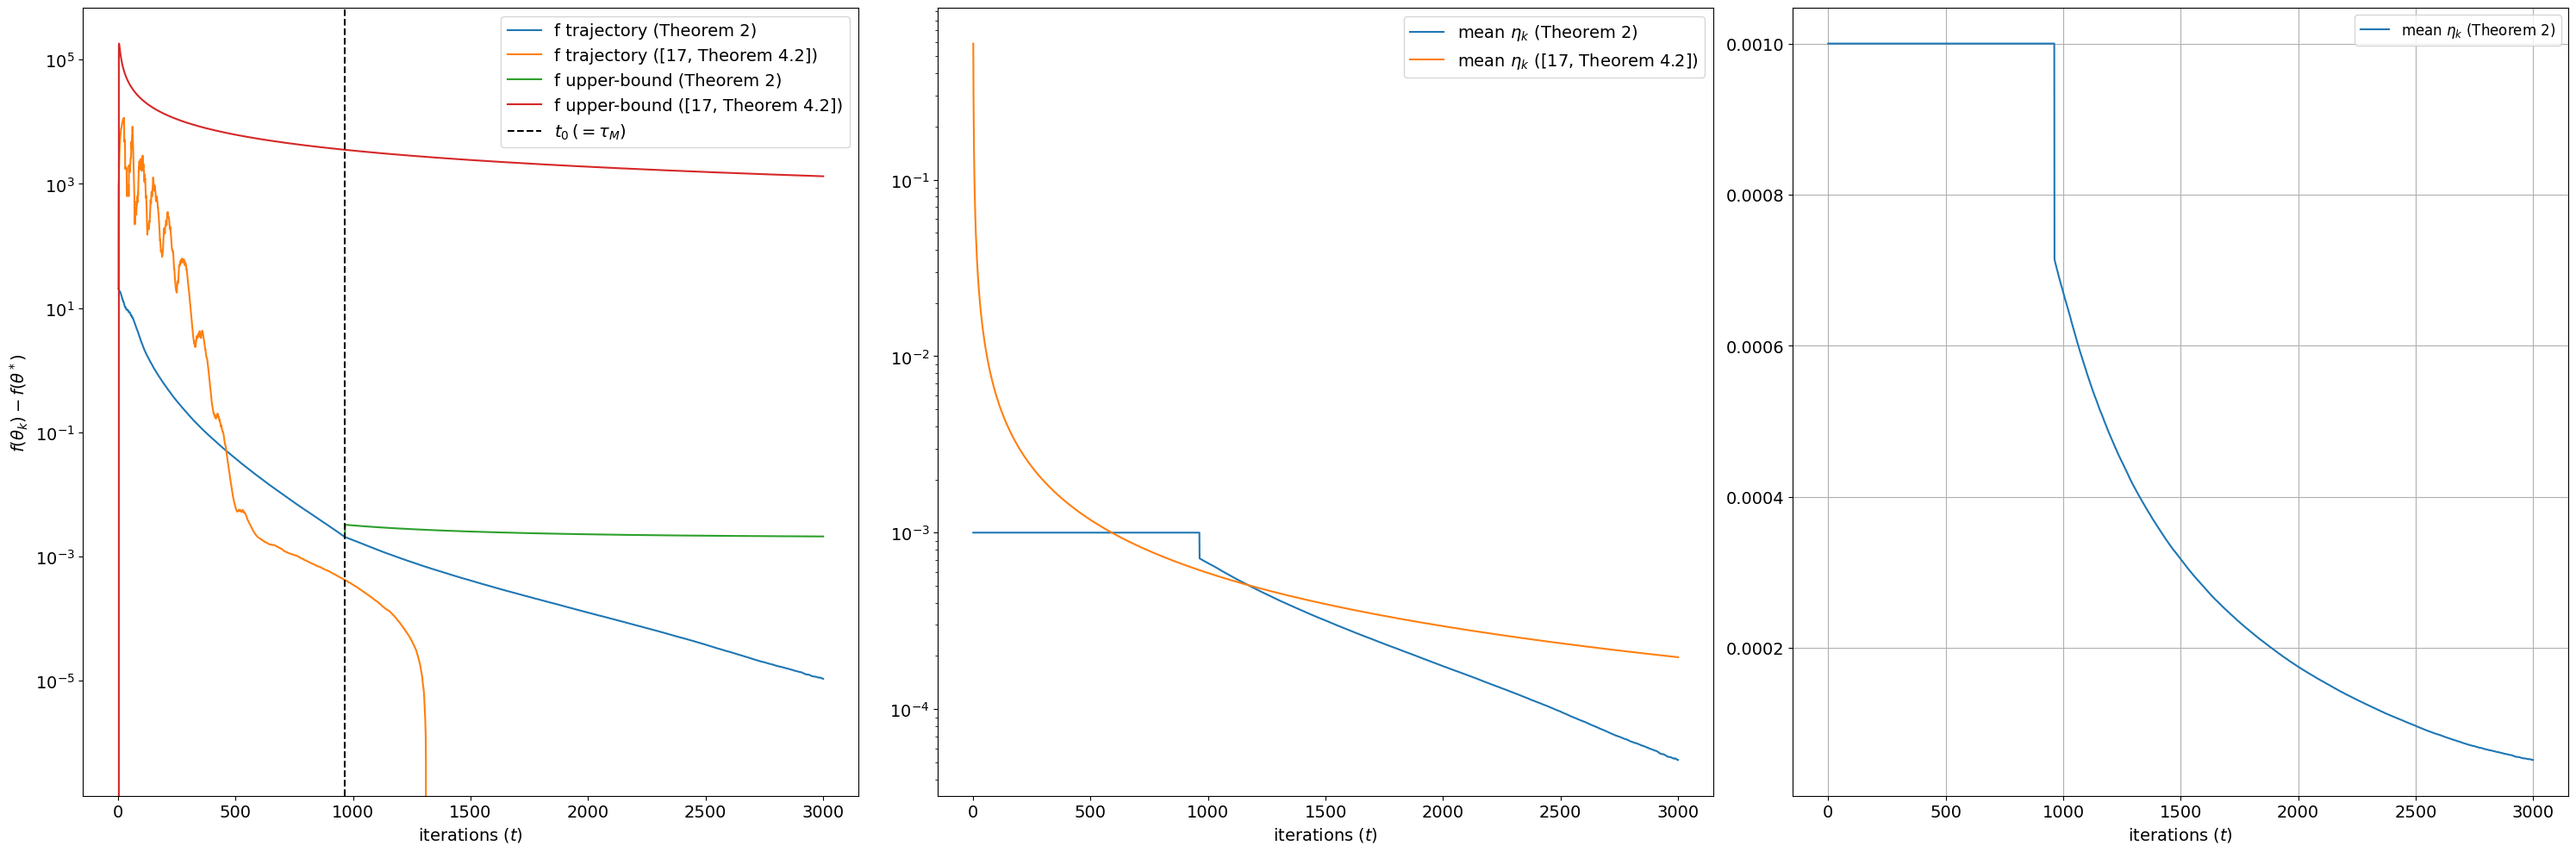

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (30, 10))
axs = axs.flatten()
ax1, ax2, ax3 = axs
# plt.subplot(1, 3, 1)

ax1.plot(np.arange(1, iterations + 2), mean_trajectory_f_1, label = 'f trajectory (Theorem 2)')
ax1.plot(np.arange(1, iterations + 2), mean_trajectory_f_42, label = 'f trajectory ([17, Theorem 4.2])')

if bounds_1 is not None and bounds_42 is not None:
    bounds_1 = np.pad(bounds_1, pad_width = (iterations - bounds_1.shape[0] + 1, 0), mode = 'constant', constant_values = np.nan)
    ax1.plot(np.arange(1, iterations + 2), bounds_1, label = 'f upper-bound (Theorem 2)')
    ax1.plot(np.arange(1, iterations + 2), (mu/2)*bounds_42, label = 'f upper-bound ([17, Theorem 4.2])')
    # ax1.axhline(np.nanmin(bounds_1), ls = '--', c = 'k', label = f'minimum upper-bound')
    ax1.axvline(tau_M, ls = '--', c = 'k', label = r'$t_0\, (= \tau_M)$')
    pass

ax1.set_xlabel(r'iterations $(t)$', fontsize = 14)
ax1.set_ylabel(r'$f(\theta_k) - f(\theta^*)$', fontsize = 14)
ax1.set_yscale('log')
# plt.grid(which = 'minor')
ax1.legend(fontsize = 14)
ax1.tick_params(axis = 'x', labelsize = 14)
ax1.tick_params(axis = 'y', labelsize = 14)


ax2.plot(np.arange(1, iterations + 1), learning_rates_1.mean(axis = 0), label = r'mean $\eta_k$ (Theorem 2)')
ax2.plot(np.arange(1, iterations + 1), learning_rates_42.mean(axis = 0), label = r'mean $\eta_k$ ([17, Theorem 4.2])')

ax2.set_xlabel(r'iterations $(t)$', fontsize = 14)
ax2.set_yscale('log')
ax2.legend(fontsize = 14)
ax2.tick_params(axis = 'x', labelsize = 14)
ax2.tick_params(axis = 'y', labelsize = 14)

x_data = np.arange(1, iterations + 1)
zoom_threshold = 3

# Modified x-axis values
# -----------------------------------------------------------------------------------------------------------------------------
# x_combined = np.concatenate([
#                                 x_data[:zoom_threshold],
#                                 zoom_threshold + (x_data[zoom_threshold:] - zoom_threshold) / 500
#                             ])

# ax3.plot(x_combined, learning_rates_1.mean(axis = 0), label=r'mean $\eta_k$ (Ours)')

# Custom x-tick labels for clarity
# x_ticks_combined = np.concatenate([
#                                     np.arange(1, zoom_threshold + 1),
#                                     np.arange(100, iterations + 1, 500)
#                                   ])
# x_tick_labels = np.concatenate([
#                                     np.arange(1, zoom_threshold + 1),
#                                     np.arange(100, iterations + 1, 500)
#                                ])

# ax3.set_xticks(x_combined[np.isin(x_data, x_ticks_combined)])
# _ = ax3.set_xticklabels(x_tick_labels)

# -----------------------------------------------------------------------------------------------------------------------------

ax3.plot(learning_rates_1.mean(axis = 0), label=r'mean $\eta_k$ (Theorem 2)')

ax3.set_xlabel(r'iterations $(t)$', fontsize = 14)
ax3.grid(which = 'major')
ax3.legend(fontsize = 12)
ax3.tick_params(axis = 'x', labelsize = 14)
ax3.tick_params(axis = 'y', labelsize = 14)

plt.tight_layout()

fig.savefig('./simulation_2a.pdf')

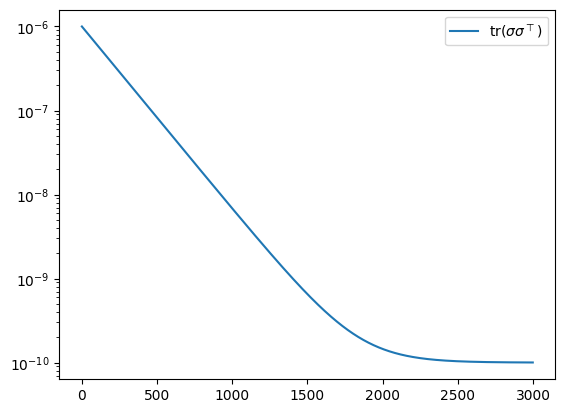

In [31]:
sigma_sq = np.asarray([1e-6 * np.exp(-0.005 * i) + 1e-10 for i in range(iterations)]).astype(np.float32)
plt.plot(sigma_sq, label = r'$\operatorname{tr}(\sigma\sigma^\top)$')
plt.yscale('log')
plt.legend()